# Start

In [71]:
# --- INSTALL LIBRARIES ---
!pip install pandas numpy matplotlib seaborn lightgbm tqdm

In [72]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [73]:
# --- DISPLAY OPTIONS ---
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set(style='whitegrid')

In [74]:
# --- LOAD MAIN DATASETS ---
application_train = pd.read_csv('./drive/MyDrive/Rakamin/home-credit-default-risk/application_train.csv')
application_test = pd.read_csv('./drive/MyDrive/Rakamin/home-credit-default-risk/application_test.csv')
bureau = pd.read_csv('./drive/MyDrive/Rakamin/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('./drive/MyDrive/Rakamin/home-credit-default-risk/bureau_balance.csv')
previous_application = pd.read_csv('./drive/MyDrive/Rakamin/home-credit-default-risk/previous_application.csv')
POS_CASH_balance = pd.read_csv('./drive/MyDrive/Rakamin/home-credit-default-risk/POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('./drive/MyDrive/Rakamin/home-credit-default-risk/credit_card_balance.csv')
installments_payments = pd.read_csv('./drive/MyDrive/Rakamin/home-credit-default-risk/installments_payments.csv')

print(f"Train shape: {application_train.shape}, Test shape: {application_test.shape}")

Train shape: (307511, 122), Test shape: (48744, 121)


# Data Cleaning and Data Preprocessing

In [75]:
# --- CHECK MISSING VALUES ---
missing_train = application_train.isnull().mean().sort_values(ascending=False)
print("Top 10 Missing Columns:\n", missing_train.head(10))

# --- SIMPLE IMPUTATION ---
# Numeric → fill with median
num_cols = application_train.select_dtypes(include=[np.number]).columns.tolist()
application_train[num_cols] = application_train[num_cols].fillna(application_train[num_cols].median())

# Categorical → fill with 'Missing'
cat_cols = application_train.select_dtypes(exclude=[np.number]).columns.tolist()
application_train[cat_cols] = application_train[cat_cols].fillna('Missing')

# --- ENCODE CATEGORICALS ---
for col in cat_cols:
    application_train[col] = application_train[col].astype('category').cat.codes

print("Cleaned training data shape:", application_train.shape)


Top 10 Missing Columns:
 COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_MEDI             0.698723
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_MODE       0.683550
dtype: float64
Cleaned training data shape: (307511, 122)


In [76]:
# Align train and test columns
train_labels = application_train['TARGET']
application_train, application_test = application_train.align(application_test, join='inner', axis=1)

print("Aligned shapes:", application_train.shape, application_test.shape)


Aligned shapes: (307511, 121) (48744, 121)


In [77]:
application_train = application_train.fillna(0)
application_test = application_test.fillna(0)

In [78]:
application_train.to_csv('application_train_processed.csv', index=False)
application_test.to_csv('application_test_processed.csv', index=False)
print("Saved cleaned datasets for modeling.")


Saved cleaned datasets for modeling.


Adding TARGET back to training data...


/tmp/ipython-input-1508016829.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  application_train['TARGET'] = train_labels.values


Top correlated features with TARGET:

TARGET                         1.000000
EXT_SOURCE_2                  -0.160295
EXT_SOURCE_3                  -0.155892
EXT_SOURCE_1                  -0.098887
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_EDUCATION_TYPE            0.054699
CODE_GENDER                    0.054692
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
NAME_INCOME_TYPE               0.046829
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                 -0.044932
Name: TARGET, dtype: float64


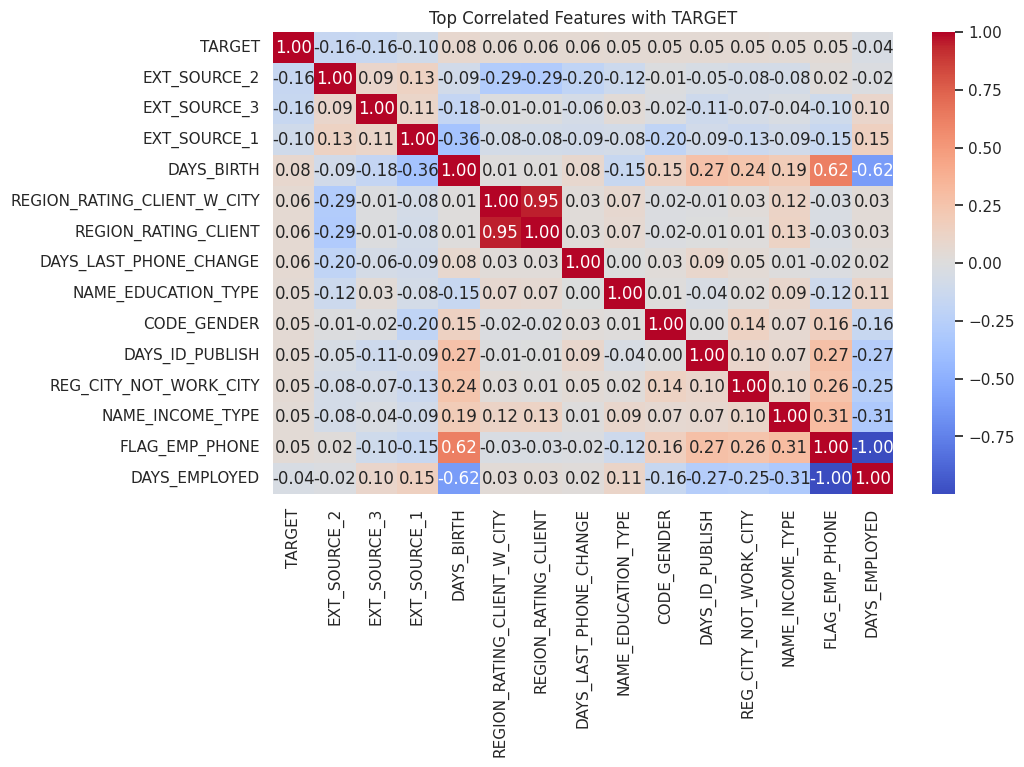

In [79]:
# --- Check Target exists ---
if 'TARGET' not in application_train.columns:
    print("Adding TARGET back to training data...")
    # re-attach if it was separated earlier
    application_train['TARGET'] = train_labels.values

# --- Select only numeric columns ---
numeric_features = application_train.select_dtypes(include=[np.number])

# --- Compute correlations safely ---
corrs = numeric_features.corr()['TARGET'].sort_values(key=lambda x: abs(x), ascending=False)

# --- Display top correlations ---
print("Top correlated features with TARGET:\n")
print(corrs.head(15))

# --- Optional: plot correlation heatmap for top 15 ---
top_corr_features = corrs.head(15).index
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_features[top_corr_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Top Correlated Features with TARGET")
plt.show()



# Feature Engineering (Aggregate Datasets)

In [80]:
# --- LOAD CLEAN DATASETS ---
application_train = pd.read_csv('application_train_processed.csv')
application_test = pd.read_csv('application_test_processed.csv')

In [81]:
# --- AGGREGATE bureau_balance ---
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['mean', 'min', 'max', 'size'],
    'STATUS': lambda x: (x == '1').sum()  # count months overdue
})

# Rename columns properly
bureau_balance_agg.columns = [
    'BB_MONTHS_BALANCE_MEAN',
    'BB_MONTHS_BALANCE_MIN',
    'BB_MONTHS_BALANCE_MAX',
    'BB_MONTHS_BALANCE_SIZE',
    'BB_STATUS_OVERDUE_COUNT'
]
bureau_balance_agg.reset_index(inplace=True)

# --- MERGE into bureau ---
bureau = bureau.merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')

# --- AGGREGATE bureau by SK_ID_CURR ---
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['mean', 'min', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'BB_STATUS_OVERDUE_COUNT': ['mean'],
    'CREDIT_ACTIVE': lambda x: (x == 'Active').sum()
})
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]
bureau_agg.reset_index(inplace=True)

print("Bureau features created:", bureau_agg.shape)


Bureau features created: (305811, 10)


In [82]:
prev_agg = previous_application.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean', 'max', 'min'],
    'AMT_CREDIT': ['mean', 'max'],
    'NAME_CONTRACT_STATUS': lambda x: (x == 'Approved').sum(),
    'DAYS_DECISION': ['mean']
})
prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]
prev_agg.reset_index(inplace=True)
print("Previous application features created:", prev_agg.shape)


Previous application features created: (338857, 8)


In [83]:
credit_agg = credit_card_balance.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['mean', 'min', 'max', 'size'],
    'AMT_BALANCE': ['mean', 'max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 'max'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['mean', 'sum']
})
credit_agg.columns = ['CC_' + '_'.join(col).upper() for col in credit_agg.columns]
credit_agg.reset_index(inplace=True)
print("Credit card features created:", credit_agg.shape)


Credit card features created: (103558, 11)


In [84]:
# --- Compute delay features ---
installments_payments['PAYMENT_DIFF'] = installments_payments['AMT_PAYMENT'] - installments_payments['AMT_INSTALMENT']
installments_payments['DAYS_DIFF'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']

inst_agg = installments_payments.groupby('SK_ID_CURR').agg({
    'PAYMENT_DIFF': ['mean', 'max', 'min'],
    'DAYS_DIFF': ['mean', 'max', 'min'],
    'AMT_PAYMENT': ['mean', 'sum']
})
inst_agg.columns = ['INST_' + '_'.join(col).upper() for col in inst_agg.columns]
inst_agg.reset_index(inplace=True)
print("Installment payment features created:", inst_agg.shape)


Installment payment features created: (339587, 9)


In [85]:
pos_agg = POS_CASH_balance.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['mean', 'min', 'max', 'size'],
    'NAME_CONTRACT_STATUS': lambda x: (x == 'Active').sum()
})
pos_agg.columns = ['POS_' + '_'.join(col).upper() for col in pos_agg.columns]
pos_agg.reset_index(inplace=True)
print("POS/CASH features created:", pos_agg.shape)


POS/CASH features created: (337252, 6)


In [86]:
# --- Sequentially merge all aggregates ---
for df in [bureau_agg, prev_agg, credit_agg, inst_agg, pos_agg]:
    application_train = application_train.merge(df, on='SK_ID_CURR', how='left')
    application_test = application_test.merge(df, on='SK_ID_CURR', how='left')

# --- Fill remaining missing values ---
application_train = application_train.fillna(0)
application_test = application_test.fillna(0)

print("Final train shape:", application_train.shape)


Final train shape: (307511, 160)


In [87]:
# --- FIX: Reattach TARGET before creating X and y ---
application_train['TARGET'] = train_labels.values

# --- Now prepare train-test split ---
X_train = application_train.drop(columns=['TARGET'])
y_train = application_train['TARGET']
X_test = application_test.copy()


# LightGBM Model

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

# --- Split validation set ---
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# --- Prepare LightGBM datasets ---
train_data = lgb.Dataset(X_tr, label=y_tr)
valid_data = lgb.Dataset(X_val, label=y_val)

# --- Parameters ---
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

# --- Train model with callback-based early stopping ---
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

# --- Evaluate ---
y_pred = model.predict(X_val, num_iteration=model.best_iteration)
roc_gbm = roc_auc_score(y_val, y_pred)
pr_auc = average_precision_score(y_val, y_pred)
print(f"Validation ROC-AUC: {roc_gbm:.4f}")
print(f"Validation PR-AUC: {pr_auc:.4f}")


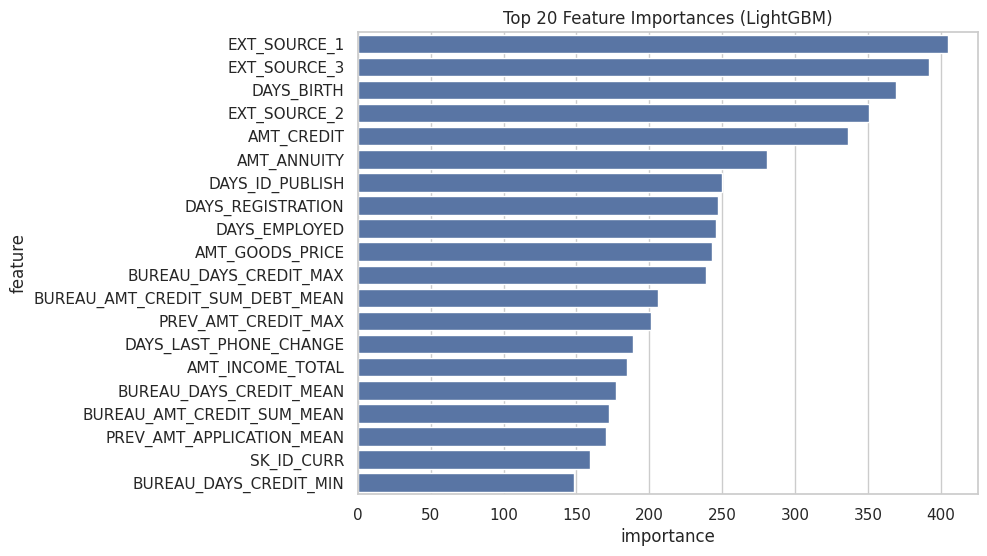

In [66]:
# --- Get feature importance ---
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(y='feature', x='importance', data=importance)
plt.title("Top 20 Feature Importances (LightGBM)")
plt.show()


In [ ]:
# --- Ensure numeric columns only ---
X_test_numeric = X_test.copy()
for col in X_test_numeric.columns:
    if not np.issubdtype(X_test_numeric[col].dtype, np.number):
        X_test_numeric[col] = pd.to_numeric(X_test_numeric[col], errors='coerce')

# --- Make predictions ---
test_pred = model.predict(X_test_numeric, num_iteration=model.best_iteration)

# --- Create submission DataFrame ---
submission = pd.DataFrame({
    'SK_ID_CURR': application_test['SK_ID_CURR'].astype(int),
    'TARGET': test_pred.astype(float)
})

# --- Save submission ---
submission.to_csv('submission_baseline.csv', index=False)
print("Saved baseline submission as submission_baseline.csv")


Saved baseline submission as submission_baseline.csv


# Logistic Regression

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report


In [ ]:
application_train = pd.read_csv('application_train_processed.csv')
application_test = pd.read_csv('application_test_processed.csv')

# Reattach target if missing
if 'TARGET' not in application_train.columns:
    application_train['TARGET'] = train_labels.values

X = application_train.drop(columns=['TARGET'])
y = application_train['TARGET']


In [ ]:
for col in X.columns:
    if not np.issubdtype(X[col].dtype, np.number):
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill any missing values with 0
X = X.fillna(0)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [64]:
X_val

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_CREDIT_ACTIVE_<LAMBDA>,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_NAME_CONTRACT_STATUS_<LAMBDA>
256571,396899,0,1,1,1,1,157500.0,770292.0,30676.5,688500.0,1,7,1,1,1,0.010147,-13506,-105,-2876.0,-4402,19.0,1,1,0,1,0,0,8,3.0,2,2,1,17,0,0,0,0,0,0,55,0.505998,0.594327,0.427657,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,0.2083,0.0481,0.0756,0.0745,0.0,0.0036,0.0840,0.0746,0.9816,0.7648,0.0190,0.0000,0.1379,0.1667,0.2083,0.0458,0.0771,0.0731,0.0,0.0011,0.0864,0.0758,0.9816,0.7585,0.0208,0.00,0.1379,0.1667,0.2083,0.0487,0.0761,0.0749,0.0,0.0031,0,0,0.0688,1,0,1.0,0.0,1.0,0.0,-428.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0,-1169.777778,-2663.0,-202.0,1.398185e+05,1258366.500,31895.7600,191374.560,4.0,46380.375,77611.5,47764.125,77611.5,3.0
191493,322041,0,0,0,0,0,90000.0,364896.0,19926.0,315000.0,1,7,4,1,1,0.007330,-17723,-4930,-4654.0,-1259,9.0,1,1,0,1,0,0,8,2.0,2,2,4,12,0,0,0,0,0,0,11,0.593554,0.619621,0.484851,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,0.2083,0.0481,0.0756,0.0745,0.0,0.0036,0.0840,0.0746,0.9816,0.7648,0.0190,0.0000,0.1379,0.1667,0.2083,0.0458,0.0771,0.0731,0.0,0.0011,0.0864,0.0758,0.9816,0.7585,0.0208,0.00,0.1379,0.1667,0.2083,0.0487,0.0761,0.0749,0.0,0.0031,0,0,0.0688,1,0,0.0,0.0,0.0,0.0,-1491.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,6.0,-233.000000,-233.0,-233.0,8.104878e+04,81048.780,36573.6600,36573.660,1.0,43773.750,229500.0,46650.600,241920.0,6.0
103497,220127,0,1,0,1,0,148500.0,284400.0,18643.5,225000.0,7,7,4,0,1,0.014464,-24200,-1191,-12511.0,-2474

In [ ]:
# Logistic Regression model
log_reg = LogisticRegression(
    max_iter=500,
    solver='lbfgs',
    class_weight='balanced',  # Helps with the class imbalance (8% defaults)
    n_jobs=-1
)

log_reg.fit(X_train_scaled, y_train)
print("Logistic Regression model trained successfully!")


Logistic Regression model trained successfully!


In [ ]:
y_pred_proba = log_reg.predict_proba(X_val_scaled)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

roc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)
print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

# Optional: Classification summary
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


ROC-AUC: 0.7531
PR-AUC: 0.2348

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503



Top 15 most influential features:
                       Feature  Coefficient  Abs_Coefficient
22              FLAG_EMP_PHONE     7.052884         7.052884
17               DAYS_EMPLOYED     6.994128         6.994128
9              AMT_GOODS_PRICE    -0.963947         0.963947
7                   AMT_CREDIT     0.890468         0.890468
42                EXT_SOURCE_3    -0.426304         0.426304
129  PREV_AMT_APPLICATION_MEAN    -0.393946         0.393946
41                EXT_SOURCE_2    -0.392583         0.392583
44            BASEMENTAREA_AVG    -0.358813         0.358813
72           BASEMENTAREA_MEDI     0.356112         0.356112
131       PREV_AMT_CREDIT_MEAN     0.337567         0.337567
81       LIVINGAPARTMENTS_MEDI     0.305495         0.305495
46             YEARS_BUILD_AVG     0.281448         0.281448
74            YEARS_BUILD_MEDI    -0.274049         0.274049
28             CNT_FAM_MEMBERS    -0.256918         0.256918
54              LIVINGAREA_AVG     0.249066        

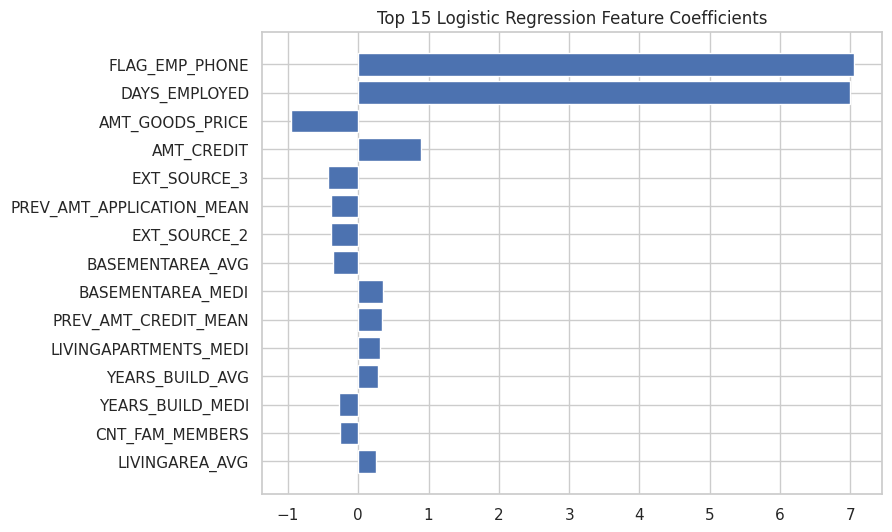

In [ ]:
# Create a DataFrame of coefficients
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
})

# Sort by absolute value (strongest impact)
importance['Abs_Coefficient'] = importance['Coefficient'].abs()
importance = importance.sort_values('Abs_Coefficient', ascending=False)

print("Top 15 most influential features:")
print(importance.head(15))

# Optional: visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.barh(importance['Feature'].head(15), importance['Coefficient'].head(15))
plt.title("Top 15 Logistic Regression Feature Coefficients")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Ensure numeric and scaled test data
X_test = application_test.copy()
for col in X_test.columns:
    if not np.issubdtype(X_test[col].dtype, np.number):
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
X_test = X_test.fillna(0)
X_test_scaled = scaler.transform(X_test)

# Predict probabilities
test_pred = log_reg.predict_proba(X_test_scaled)[:, 1]

# Save submission
submission_logreg = pd.DataFrame({
    'SK_ID_CURR': application_test['SK_ID_CURR'].astype(int),
    'TARGET': test_pred
})
submission_logreg.to_csv('submission_logistic_regression.csv', index=False)
print("Saved logistic regression submission as submission_logistic_regression.csv")


Saved logistic regression submission as submission_logistic_regression.csv


In [ ]:
print("LightGBM ROC-AUC:", roc_gbm)
print("Logistic Regression ROC-AUC:", roc_auc_score(y_val, y_pred_proba))


LightGBM ROC-AUC: 0.7596868829095289
Logistic Regression ROC-AUC: 0.7531077940361263
